Average Temperature and Humidity when Fan is ON:
     avg_temp  avg_humidity
0  28.071252     44.369952

Total Watering Pump ON vs OFF:
    total_water_on  total_water_off
0          9022.0          28900.0


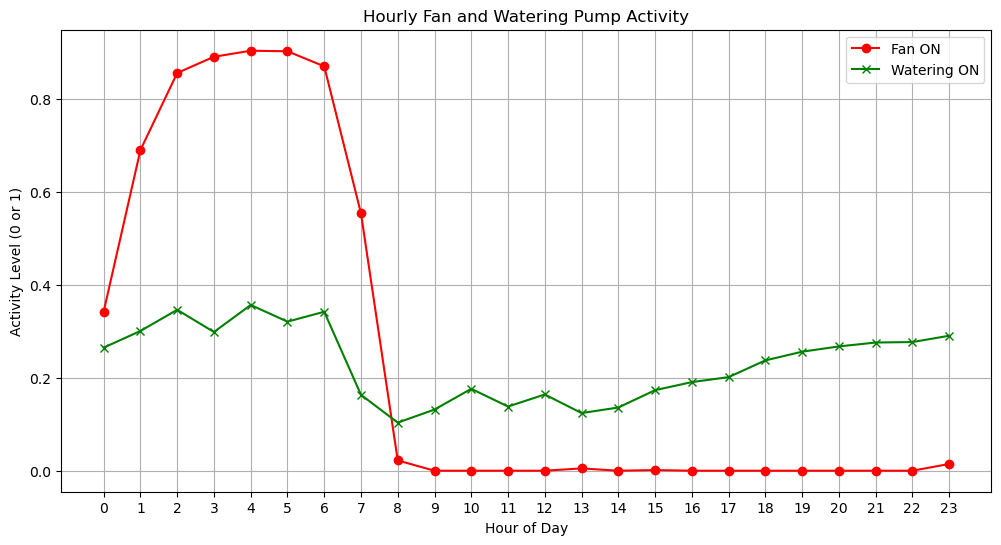

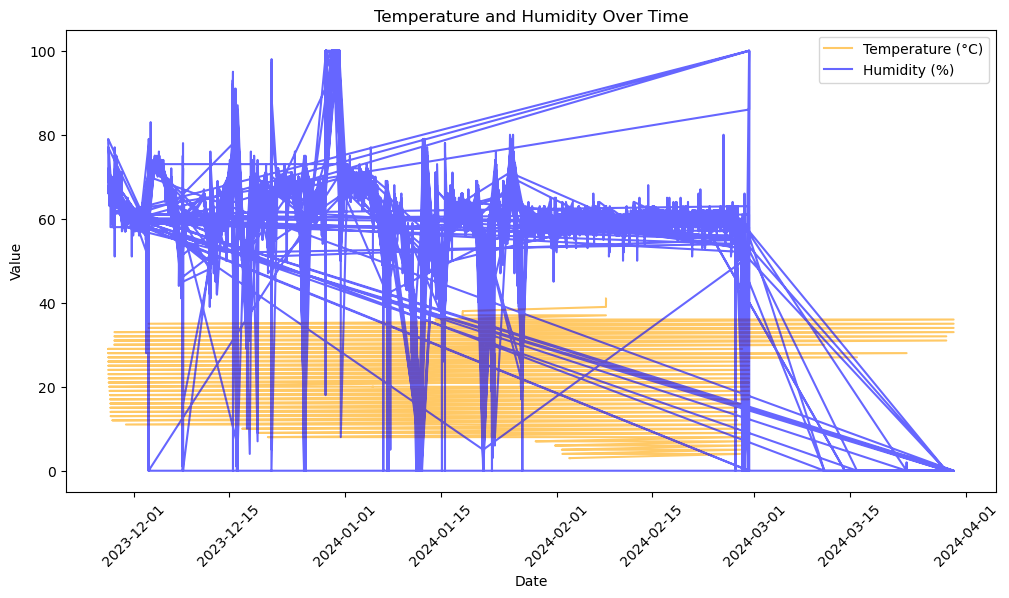

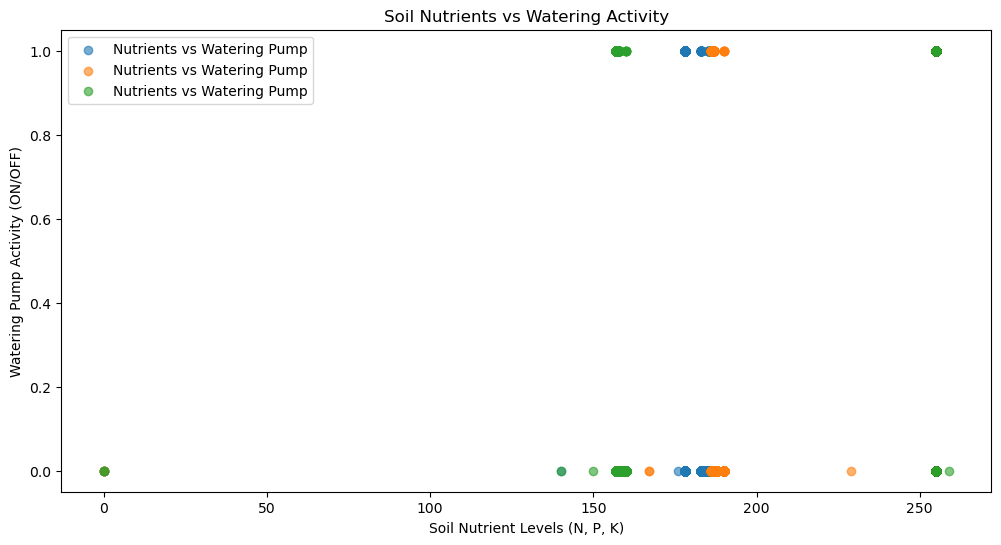

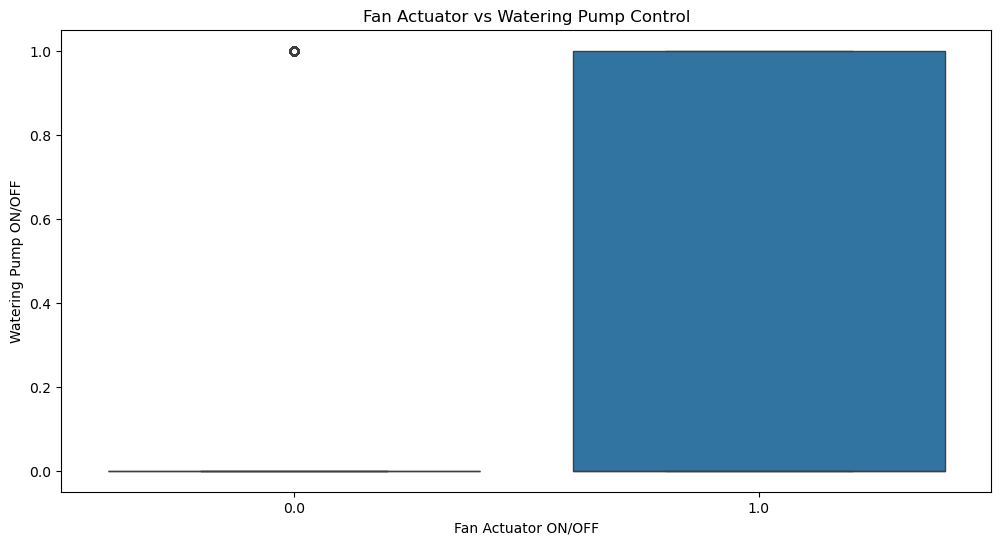


Watering Pump Model Accuracy (Gradient Boosting): 1.0
Watering Pump Classification Report (Gradient Boosting):
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5828
         1.0       1.00      1.00      1.00      1757

    accuracy                           1.00      7585
   macro avg       1.00      1.00      1.00      7585
weighted avg       1.00      1.00      1.00      7585


Average Temperature and Humidity (Day vs Night):
   day_night  avg_temp  avg_humidity
0       Day  17.31601     54.608403
1     Night  20.14851     46.215446

Best Parameters from Grid Search: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Optimized Model Accuracy: 1.0
Optimized Model Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5828
         1.0       1.00      1.00      1.00      1757

    accuracy                           1.00      7585
   macro avg    

In [9]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# Load dataset
file_path = "IoTProcessed_Data.csv"
df = pd.read_csv(file_path)

# Convert date to datetime format
df['date'] = pd.to_datetime(df['date'])

# Create SQLite database and table
conn = sqlite3.connect("climate_control.db")
df.to_sql("climate_data", conn, if_exists="replace", index=False)

# Query: Average temperature and humidity when fan is ON
query = """
SELECT AVG(tempreature) AS avg_temp, AVG(humidity) AS avg_humidity
FROM climate_data
WHERE Fan_actuator_ON = 1
"""
result = pd.read_sql(query, conn)
print("Average Temperature and Humidity when Fan is ON:\n", result)

# Query: Total number of times watering pump was ON vs. OFF
query2 = """
SELECT SUM(Watering_plant_pump_ON) AS total_water_on, SUM(Watering_plant_pump_OFF) AS total_water_off
FROM climate_data
"""
result2 = pd.read_sql(query2, conn)
print("\nTotal Watering Pump ON vs OFF:\n", result2)

# 1. Hourly Fan and Watering Pump Activity
df['hour'] = df['date'].dt.hour
hourly_activity = df.groupby('hour')[['Fan_actuator_ON', 'Watering_plant_pump_ON']].mean()

# Plotting hourly fan and watering pump activity
plt.figure(figsize=(12, 6))
plt.plot(hourly_activity.index, hourly_activity['Fan_actuator_ON'], label='Fan ON', color='red', marker='o')
plt.plot(hourly_activity.index, hourly_activity['Watering_plant_pump_ON'], label='Watering ON', color='green', marker='x')
plt.xlabel('Hour of Day')
plt.ylabel('Activity Level (0 or 1)')
plt.title('Hourly Fan and Watering Pump Activity')
plt.legend()
plt.xticks(range(24))
plt.grid(True)
plt.show()

# 2. Temperature and Humidity Over Time
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['tempreature'], label='Temperature (°C)', color='orange', alpha=0.6)
plt.plot(df['date'], df['humidity'], label='Humidity (%)', color='blue', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Temperature and Humidity Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 3. Soil Nutrients vs Watering Activity
plt.figure(figsize=(12, 6))
plt.scatter(df['N'], df['Watering_plant_pump_ON'], alpha=0.6, label='Nutrients vs Watering Pump')
plt.scatter(df['P'], df['Watering_plant_pump_ON'], alpha=0.6, label='Nutrients vs Watering Pump')
plt.scatter(df['K'], df['Watering_plant_pump_ON'], alpha=0.6, label='Nutrients vs Watering Pump')
plt.xlabel('Soil Nutrient Levels (N, P, K)')
plt.ylabel('Watering Pump Activity (ON/OFF)')
plt.title('Soil Nutrients vs Watering Activity')
plt.legend()
plt.show()

# 4. Fan Actuator vs Watering Pump Control
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Fan_actuator_ON', y='Watering_plant_pump_ON')
plt.title('Fan Actuator vs Watering Pump Control')
plt.xlabel('Fan Actuator ON/OFF')
plt.ylabel('Watering Pump ON/OFF')
plt.show()

# 5. Advanced Predictive Model - Gradient Boosting for Watering Pump Control

# Prepare dataset for watering pump prediction
features2 = ['tempreature', 'humidity', 'water_level']
target2 = 'Watering_plant_pump_ON'
X2 = df[features2]
y2 = df[target2]

# Drop NaN values and split dataset into training and testing sets
df = df.dropna()
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Train a Gradient Boosting Classifier for watering pump control
model_gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
model_gb.fit(X2_train, y2_train)

# Make predictions
y2_pred_gb = model_gb.predict(X2_test)

# Evaluate model performance
accuracy2_gb = accuracy_score(y2_test, y2_pred_gb)
print("\nWatering Pump Model Accuracy (Gradient Boosting):", accuracy2_gb)
print("Watering Pump Classification Report (Gradient Boosting):\n", classification_report(y2_test, y2_pred_gb))

# 6. Additional Query - Temperature and Humidity Comparison (Day vs Night)
df['day_night'] = df['hour'].apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')

# Insert the updated 'day_night' column back into the SQLite database
df.to_sql("climate_data", conn, if_exists="replace", index=False)

# Query to get average temperature and humidity by day/night
query3 = """
SELECT day_night, AVG(tempreature) AS avg_temp, AVG(humidity) AS avg_humidity
FROM climate_data
GROUP BY day_night
"""
result3 = pd.read_sql(query3, conn)
print("\nAverage Temperature and Humidity (Day vs Night):\n", result3)

# 7. Model Hyperparameter Tuning for Improved Performance

# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV for model optimization
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X2_train, y2_train)

# Best parameters and model evaluation
print("\nBest Parameters from Grid Search:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred_optimized = best_model.predict(X2_test)

# Evaluate optimized model
optimized_accuracy = accuracy_score(y2_test, y_pred_optimized)
print("Optimized Model Accuracy:", optimized_accuracy)
print("Optimized Model Classification Report:\n", classification_report(y2_test, y_pred_optimized))

# 8. Additional Queries (Examples)
# Query to get total fan activity per hour
query4 = """
SELECT strftime('%H', date) AS hour, 
       SUM(Fan_actuator_ON) AS total_fan_on, 
       SUM(Fan_actuator_OFF) AS total_fan_off
FROM climate_data
GROUP BY hour
"""
result4 = pd.read_sql(query4, conn)
print("\nTotal Fan ON/OFF Activity by Hour:\n", result4)

# Query to get total watering pump activity vs. soil nutrients (N, P, K)
query5 = """
SELECT N, P, K, 
       SUM(Watering_plant_pump_ON) AS total_water_on, 
       SUM(Watering_plant_pump_OFF) AS total_water_off
FROM climate_data
GROUP BY N, P, K
ORDER BY N, P, K
"""
result5 = pd.read_sql(query5, conn)
print("\nWatering Pump Activity vs Soil Nutrients:\n", result5)

# Query to get average temperature by hour
query6 = """
SELECT strftime('%H', date) AS hour, 
       AVG(tempreature) AS avg_temp
FROM climate_data
GROUP BY hour
ORDER BY hour;
"""
result6 = pd.read_sql(query6, conn)
print("\nAverage Temperature by Hour:\n", result6)

# Close DB connection
conn.close()
